# Setup

In [1]:
from __future__ import division, print_function

import numpy as np
from scipy.constants import c, e
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Beam

In [2]:
# INPUTS
n_mp = int(1e6)

dE = np.random.randn(n_mp) * 1e6 # [eV]
dt = np.random.randn(n_mp) * 1e-7 # [s]

gamma = 1.5

beta_x = 15
beta_y = 20
D_x = 2
epsn_x = 2e-6
epsn_y = 2e-6

In [3]:
# COMPUTED QUANTITIES
beta = np.sqrt(1 - gamma**-2)
dp = dE / (beta * c)
mu_x = np.random.randn(n_mp) * np.sqrt(epsn_x)
mu_y = np.random.randn(n_mp) * np.sqrt(epsn_y)

x = np.sqrt(beta_x) * mu_x + D_x * dp
y = np.sqrt(beta_y) * mu_y
z_beamframe = (-dt * beta * c) * gamma # Lorentz transformed

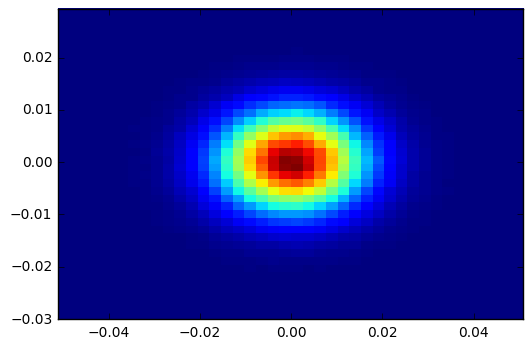

In [4]:
plt.hist2d(x, y, bins=40);

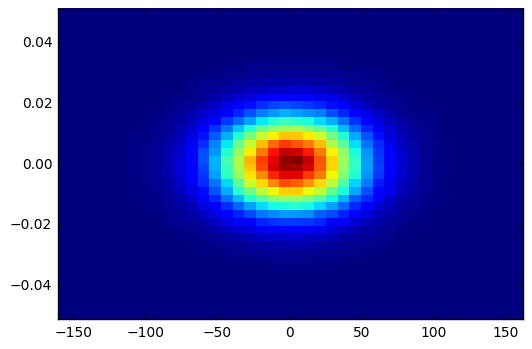

In [5]:
plt.hist2d(z_beamframe, x, bins=40);

### PyPIC Imports

In [6]:
# Import PyPIC, the particle-in-cell solver
# (to be found on github.com/PyCOMPLETE/PyPIC
# on the release/integrate-GPU branch as of 2.2.2017, 
# to be released to master branch at the end of February)
# don't forget to `make` before running here
import sys, os

sys.path.append(os.path.expanduser('~/cern/git/PyPIClib/')) # path to the PyPIC directory

# modules inside the PyPIC/GPU directory:
try: 
    from GPU.pypic import PyPIC_GPU
    from GPU.poisson_solver.FFT_solver import GPUFFTPoissonSolver, GPUFFTPoissonSolver_2_5D
    from GPU import meshing
except ImportError:
    from pypic import PyPIC_GPU
    from poisson_solver.FFT_solver import GPUFFTPoissonSolver, GPUFFTPoissonSolver_2_5D
    import meshing

Shared libraries of Fortran versions of m2p/p2m (rhocompute, int_field_for, int_field_for_border) not found. Limited functionality
PyKLU not found
cusolver_Rf not found


### GPU Setup

In [7]:
# GPU set-up, requires pycuda package

arraylib = np
mathlib = np
from pycuda.autoinit import context
from pycuda import cumath
from pycuda import gpuarray as gp
arraylib = gp
mathlib = cumath

try:
    # ensure everything is on CPU host RAM
    x, y, z = x.get(), y.get(), z.get()
except AttributeError:
    pass

### Mesh

In [8]:
# nodes for the 3D mesh
n_nodes = 64, 64, 64
distances = map(
    lambda ary, n: (np.max(ary) - np.min(ary)) / (n - 3), 
    [x, y, z_beamframe], n_nodes)
origin = map(
    lambda ary, d: ary.min() - d,
    [x, y, z_beamframe], distances)

mesh = meshing.RectMesh3D(
    origin=origin,
    distances=distances,
    n_cells_per_direction=n_nodes,
    mathlib=cumath
)

# Everything ready

### 3D field solving

In [9]:
solver = GPUFFTPoissonSolver(mesh, context=context)
# takes a mesh due to preallocation of memory (even though it's not soooo beautiful :D)

In [10]:
algorithm = PyPIC_GPU(mesh, solver, context)

In [11]:
# send arrays to GPU device RAM:
x, y, z_beamframe = map(gp.to_gpu, [x, y, z_beamframe])

In [12]:
# check all particles are on mesh
node_ids = mesh.get_indices(x, y, z_beamframe) 
assert all(np.all(
        (0 <= nids).get() & (nids < n).get()
    ) for nids, n in zip(node_ids, n_nodes))

In [13]:
%%timeit
# electric fields in the beam frame
global E_x, E_y, E_z
E_x, E_y, E_z = algorithm.pic_solve(x, y, z_beamframe, charge=e)
# before 129ms per loop

The slowest run took 7.45 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 135 ms per loop


In [14]:
# get arrays back to CPU host RAM:
x, y, z_beamframe = x.get(), y.get(), z_beamframe.get()
E_x, E_y, E_z = E_x.get(), E_y.get(), E_z.get()

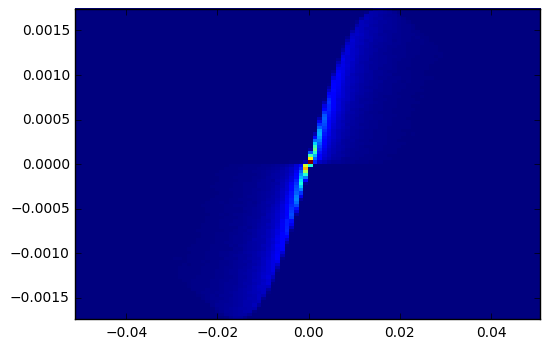

In [15]:
plt.hist2d(x, E_x, bins=100);

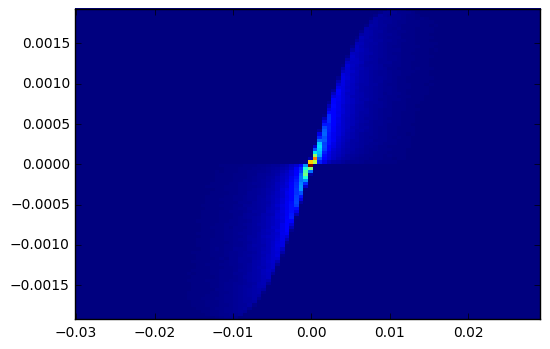

In [16]:
plt.hist2d(y, E_y, bins=100);

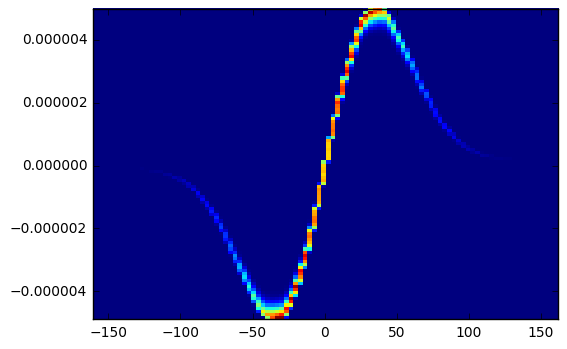

In [17]:
plt.hist2d(z_beamframe, E_z, bins=100);

### 2.5D field solving

Transverse solving along all slices defined by z direction of mesh:

In [18]:
solver25d = GPUFFTPoissonSolver_2_5D(mesh, context=context, save_memory=False)

In [19]:
algorithm25d = PyPIC_GPU(mesh, solver25d, context)

In [20]:
# send arrays to GPU device RAM:
x, y, z_beamframe = map(gp.to_gpu, [x, y, z_beamframe])

In [21]:
%%timeit
# electric fields in the beam frame
global E_x, E_y
E_x, E_y, _ = algorithm25d.pic_solve(x, y, z_beamframe, charge=e)
#before 116ms per loop

10 loops, best of 3: 133 ms per loop


In [22]:
# get arrays back to CPU host RAM:
x, y, z_beamframe = x.get(), y.get(), z_beamframe.get()
E_x, E_y = E_x.get(), E_y.get()

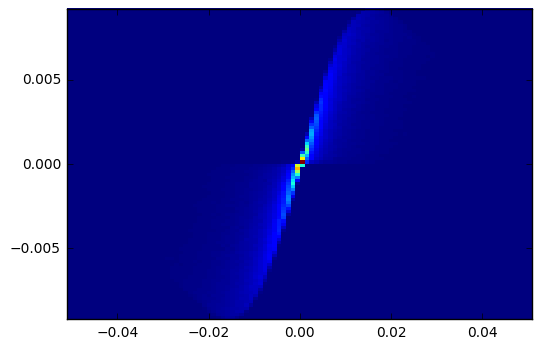

In [23]:
plt.hist2d(x, E_x, bins=100);

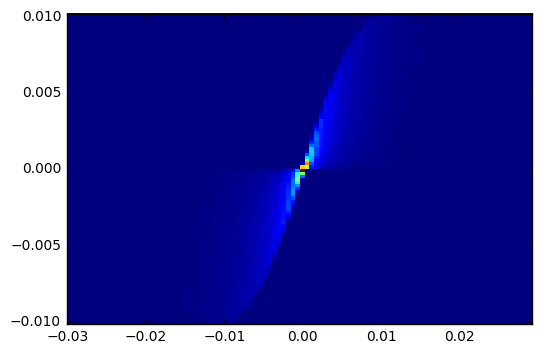

In [24]:
plt.hist2d(y, E_y, bins=100);

### Inspection

In [25]:
# send arrays to GPU device RAM:
x, y, z_beamframe = map(gp.to_gpu, [x, y, z_beamframe])

#### 3D case

In [26]:
%%timeit
global mesh_charges
mesh_charges = algorithm.particles_to_mesh(x, y, z_beamframe)
#before 58ms per loop

10 loops, best of 3: 68.8 ms per loop


In [27]:
%%timeit
global phi
phi = algorithm.poisson_solve(mesh_charges / mesh.volume_elem)
#before 9.13ms per loop

100 loops, best of 3: 4.84 ms per loop


In [28]:
%%timeit
global E_x_mesh, E_y_mesh, E_z_mesh
E_x_mesh, E_y_mesh, E_z_mesh = algorithm.get_electric_fields(phi)
context.synchronize()
#before 777us per loop

1000 loops, best of 3: 1e+03 µs per loop


In [29]:
%%timeit
global fields
fields = algorithm25d.field_to_particles(
    (E_x_mesh, x), (E_y_mesh, y), (E_z_mesh, z_beamframe)
)
#before 52ms per loop

10 loops, best of 3: 62.6 ms per loop


#### 2.5D case

In [30]:
%%timeit
global mesh_charges
mesh_charges = algorithm25d.particles_to_mesh(x, y, z_beamframe)
#before 57.7ms per loop

10 loops, best of 3: 67.6 ms per loop


In [31]:
%%timeit
global phi
phi = algorithm25d.poisson_solve(mesh_charges / (mesh.dx * mesh.dy))
#before 4.87ms per loop

100 loops, best of 3: 4.47 ms per loop


In [32]:
%%timeit
global E_x_mesh, E_y_mesh, dummy
E_x_mesh, E_y_mesh, dummy = algorithm25d.get_electric_fields(phi)
context.synchronize()
#before 788us per loop

1000 loops, best of 3: 993 µs per loop


In [33]:
%%timeit
global fields
fields = algorithm25d.field_to_particles(
    (E_x_mesh, x), (E_y_mesh, y), (dummy, z_beamframe)
)
#before 51.1ms per loop

10 loops, best of 3: 62.7 ms per loop


#### done:

In [34]:
# get arrays back to CPU host RAM:
x, y, z_beamframe = x.get(), y.get(), z_beamframe.get()

.

.

.

.

.

.

.

.

.

.

# meshing

In [35]:
mesh.mathlib = np

In [36]:
%%timeit
global weights_numpy
weights_numpy = mesh.get_weights(x, y, z_beamframe)
#before 204ms per loop

10 loops, best of 3: 96.6 ms per loop


In [37]:
mesh.mathlib = cumath

In [38]:
# send arrays to GPU device RAM:
x, y, z_beamframe = map(gp.to_gpu, [x, y, z_beamframe])

In [39]:
%%timeit
global weights
weights = mesh.get_weights(x, y, z_beamframe)
#before 37.9ms per loop

10 loops, best of 3: 59.6 ms per loop


In [40]:
np.allclose(weights[0].get(), weights_numpy[0])

False

In [41]:
error = np.abs(weights[0].get() - weights_numpy[0])
error_ids = np.where(error > 1e-5)
print (error_ids, error[error_ids])

(array([440279]),) [ 0.38598574]


In [42]:
mesh.get_indices(x[440279], y[440279], z_beamframe[440279])

(array(62, dtype=int32), array(31, dtype=int32), array(33, dtype=int32))

In [43]:
from pycuda.elementwise import ElementwiseKernel

In [44]:
get_weights_new = ElementwiseKernel(
    # inputs:
    'double* x, double* y, double* z, '
    # outputs:
    'double* weight_ijk, double* weight_i1jk, '
    'double* weight_ij1k, double* weight_i1j1k, '
    'double* weight_ijk1, double* weight_i1jk1, '
    'double* weight_ij1k1, double* weight_i1j1k1',
    '''
    // indices
    double jj = floor((x[i] - {x0:{prec}}) / {dx:{prec}});
    double ii = floor((y[i] - {y0:{prec}}) / {dy:{prec}});
    double kk = floor((z[i] - {z0:{prec}}) / {dz:{prec}});
    
    // distances
    double dxi = x[i] - ({x0:{prec}} + jj * {dx:{prec}});
    double dyi = y[i] - ({y0:{prec}} + ii * {dy:{prec}});
    double dzi = z[i] - ({z0:{prec}} + kk * {dz:{prec}});
    
    // weights
    weight_ijk[i] =    (1.-dxi/{dx:{prec}})*(1.-dyi/{dy:{prec}})*(1.-dzi/{dz:{prec}});
    weight_i1jk[i] =   (1.-dxi/{dx:{prec}})*(dyi/{dy:{prec}})   *(1.-dzi/{dz:{prec}});
    weight_ij1k[i] =   (dxi/{dx:{prec}})   *(1.-dyi/{dy:{prec}})*(1.-dzi/{dz:{prec}});
    weight_i1j1k[i] =  (dxi/{dx:{prec}})   *(dyi/{dy:{prec}})   *(1.-dzi/{dz:{prec}});
    weight_ijk1[i] =   (1.-dxi/{dx:{prec}})*(1.-dyi/{dy:{prec}})*(dzi/{dz:{prec}});
    weight_i1jk1[i] =  (1.-dxi/{dx:{prec}})*(dyi/{dy:{prec}})   *(dzi/{dz:{prec}});
    weight_ij1k1[i] =  (dxi/{dx:{prec}})   *(1.-dyi/{dy:{prec}})*(dzi/{dz:{prec}});
    weight_i1j1k1[i] = (dxi/{dx:{prec}})   *(dyi/{dy:{prec}})   *(dzi/{dz:{prec}});
    '''.format(
        x0=mesh.x0, y0=mesh.y0, z0=mesh.z0, 
        dx=mesh.dx, dy=mesh.dy, dz=mesh.dz,
        prec=".17"
    ), 
    'get_weights'
)

In [45]:
%%timeit -n 100

global weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k, \
weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1

(weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k,
weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1) = (
    gp.empty_like(x) for _ in range(8)
)

get_weights_new(
    # inputs:
    x, y, z_beamframe,
    # outputs:
    weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k,
    weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1
)
context.synchronize()
#before 3.73ms per loop

100 loops, best of 3: 5.78 ms per loop


In [46]:
np.allclose(weights_numpy[0], weight_ijk.get(), atol=1e-14, rtol=1e-15)

True

In [47]:
# get arrays back to CPU host RAM:
x, y, z_beamframe = x.get(), y.get(), z_beamframe.get()

### CPU version of C/CUDA code?

In [48]:
%load_ext Cython

In [49]:
%load_ext autoreload
%autoreload 2

In [50]:
# compilable with $gcc -std=c99 -fPIC -shared -o get_weights_c.so get_weights_c.c -lm 
with open('get_weights_c.c', 'wt') as fh:
    fh.write('''
#include <math.h>

void get_weights_c(
    // inputs:
    double* x, double* y, double* z,
    int n,
    // outputs:
    double* weight_ijk, double* weight_i1jk,
    double* weight_ij1k, double* weight_i1j1k,
    double* weight_ijk1, double* weight_i1jk1,
    double* weight_ij1k1, double* weight_i1j1k1
) {{
    double jj, ii, kk;
    double dxi, dyi, dzi;
    for (int i = 0; i < n; i++) {{
        // indices
        double jj = floor((x[i] - {x0:{prec}}) / {dx:{prec}});
        double ii = floor((y[i] - {y0:{prec}}) / {dy:{prec}});
        double kk = floor((z[i] - {z0:{prec}}) / {dz:{prec}});

        // distances
        double dxi = x[i] - ({x0:{prec}} + jj * {dx:{prec}});
        double dyi = y[i] - ({y0:{prec}} + ii * {dy:{prec}});
        double dzi = z[i] - ({z0:{prec}} + kk * {dz:{prec}});

        // weights
        weight_ijk[i] =    (1.-dxi/{dx:{prec}})*(1.-dyi/{dy:{prec}})*(1.-dzi/{dz:{prec}});
        weight_i1jk[i] =   (1.-dxi/{dx:{prec}})*(dyi/{dy:{prec}})   *(1.-dzi/{dz:{prec}});
        weight_ij1k[i] =   (dxi/{dx:{prec}})   *(1.-dyi/{dy:{prec}})*(1.-dzi/{dz:{prec}});
        weight_i1j1k[i] =  (dxi/{dx:{prec}})   *(dyi/{dy:{prec}})   *(1.-dzi/{dz:{prec}});
        weight_ijk1[i] =   (1.-dxi/{dx:{prec}})*(1.-dyi/{dy:{prec}})*(dzi/{dz:{prec}});
        weight_i1jk1[i] =  (1.-dxi/{dx:{prec}})*(dyi/{dy:{prec}})   *(dzi/{dz:{prec}});
        weight_ij1k1[i] =  (dxi/{dx:{prec}})   *(1.-dyi/{dy:{prec}})*(dzi/{dz:{prec}});
        weight_i1j1k1[i] = (dxi/{dx:{prec}})   *(dyi/{dy:{prec}})   *(dzi/{dz:{prec}});
    }}
}}
    '''.format(
        x0=mesh.x0, y0=mesh.y0, z0=mesh.z0, 
        dx=mesh.dx, dy=mesh.dy, dz=mesh.dz,
        prec=".17")
    )

##### ctypes import

In [51]:
!gcc -std=c99 -fPIC -shared -o get_weights_c.so get_weights_c.c -lm

In [52]:
import ctypes

In [53]:
from numpy.ctypeslib import ndpointer
np_double_p = ndpointer(dtype=np.float64)

In [54]:
dll = ctypes.cdll.LoadLibrary('get_weights_c.so')
dll.get_weights_c.restype = None
dll.get_weights_c.argtypes = [
    np_double_p, np_double_p, np_double_p, ctypes.c_int, 
    np_double_p, np_double_p, np_double_p, np_double_p,
    np_double_p, np_double_p, np_double_p, np_double_p]

In [55]:
%%timeit -n 10

global weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k, \
weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1

(weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k,
weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1) = (
    np.empty_like(x) for _ in range(8)
)

dll.get_weights_c(
    x, y, z_beamframe, ctypes.c_int(len(x)),
    weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k,
    weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1
)

10 loops, best of 3: 223 ms per loop


In [56]:
np.allclose(weights_numpy[0], weight_ijk, atol=1e-14, rtol=1e-15)

True

##### cython import

In [57]:
%%cython --name get_weights_cy
# distutils: sources = ./get_weights_c.c
# distutils: extra_compile_args = -std=c99 -O3 -lm

import numpy as np
cimport numpy as np

cdef extern void get_weights_c(
        # inputs:
        double* x, double* y, double* z,
        int n,
        # outputs:
        double* weight_ijk, double* weight_i1jk,
        double* weight_ij1k, double* weight_i1j1k,
        double* weight_ijk1, double* weight_i1jk1,
        double* weight_ij1k1, double* weight_i1j1k1)

def get_weights(x, y, z):
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] x_c = np.ascontiguousarray(x, dtype=np.double)
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] y_c = np.ascontiguousarray(y, dtype=np.double)
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] z_c = np.ascontiguousarray(z, dtype=np.double)
    
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] weight_ijk = np.empty_like(x_c)
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] weight_i1jk = np.empty_like(x_c)
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] weight_ij1k = np.empty_like(x_c)
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] weight_i1j1k = np.empty_like(x_c)
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] weight_ijk1 = np.empty_like(x_c)
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] weight_i1jk1 = np.empty_like(x_c)
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] weight_ij1k1 = np.empty_like(x_c)
    cdef np.ndarray[np.double_t, ndim=1, mode="c"] weight_i1j1k1 = np.empty_like(x_c)
    
    get_weights_c(
        &x_c[0], &y_c[0], &z_c[0], len(x_c),
        &weight_ijk[0], &weight_i1jk[0],
        &weight_ij1k[0], &weight_i1j1k[0],
        &weight_ijk1[0], &weight_i1jk1[0],
        &weight_ij1k1[0], &weight_i1j1k1[0]
    )
    
    return (weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k,
            weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1)

In [58]:
import get_weights_cy

In [59]:
%%timeit -n 10

global weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k, \
weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1

(weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k,
weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1) = \
    get_weights_cy.get_weights(x, y, z_beamframe)

10 loops, best of 3: 58.4 ms per loop


In [60]:
np.allclose(weights_numpy[0], weight_ijk, atol=1e-14, rtol=1e-15)

True

##### so cython is 4x faster than the normal numpy version or the compiled C ctypes-imported version!

# double atomicAdd version emulated vs. hardware-accelerated

In [48]:
context.get_device().name()

'Tesla P100-SXM2-16GB'

The Tesla P100 supports cuda computing compatibility 6.0 which includes hardware accelerated double atomics.

Here, we compare the timing of the usual emulated double atomics to the new hardware accelerated version for numbers that are relevant for PIC algorithms in beam dynamics.

In [49]:
from pycuda.compiler import SourceModule

In [50]:
tmod = SourceModule(
'''static __inline__ __device__ double atomicAdd_emu(double* address, double val)
{
    unsigned long long int* address_as_ull =
                              (unsigned long long int*)address;
    unsigned long long int old = *address_as_ull, assumed;

    if (val==0.0)
        return __longlong_as_double(old);
    do {
        assumed = old;
        old = atomicCAS(address_as_ull, assumed,
                        __double_as_longlong(val +
                               __longlong_as_double(assumed)));

    // Note: uses integer comparison to avoid hang in case of NaN (since NaN != NaN)
    } while (assumed != old);

    return __longlong_as_double(old);
}

extern "C" {

__global__ void p2m_emu(int dest_size, int src_size, double* dest, double* src) {
    int pidx = blockIdx.x * blockDim.x + threadIdx.x;
    if (pidx < src_size) {
        int idx = pidx % dest_size;
        atomicAdd_emu(&dest[idx], src[pidx]);
    }
}

__global__ void p2m_acc(int dest_size, int src_size, double* dest, double* src) {
    int pidx = blockIdx.x * blockDim.x + threadIdx.x;
    if (pidx < src_size) {
        int idx = pidx % dest_size;
        atomicAdd(&dest[idx], src[pidx]);
    }
}

}
''')


In [51]:
p2m_emu = tmod.get_function('p2m_emu')
p2m_acc = tmod.get_function('p2m_acc')

p2m_emu.prepare('iiPP')
p2m_acc.prepare('iiPP')

In [52]:
src_size = int(1e8)
dest_size = 128*128*64

np.random.seed(42)
src_np = np.random.rand(src_size)
src = gp.to_gpu(src_np)

# dest_np = np.zeros(dest_size, dtype=np.float64)
# for pidx in xrange(src_size):
#     idx = pidx % dest_size
#     dest_np[idx] += src_np[pidx]
intermediate = np.zeros((src_size // dest_size + 1) * dest_size, dtype=np.float64)
intermediate[:src_size] = src_np
dest_np = intermediate.reshape(-1, dest_size).sum(axis=0)

In [53]:
dest1 = gp.zeros(dest_size, dtype=np.float64)
p2m_emu.prepared_call(
    (src_size // 256 + 1, 1, 1), #grid
    (256, 1, 1), #block
    dest_size, src_size, 
    dest1.gpudata, src.gpudata)

In [54]:
assert np.allclose(dest_np, dest1.get())

In [55]:
dest2 = gp.zeros(dest_size, dtype=np.float64)
p2m_acc.prepared_call(
    (src_size // 256 + 1, 1, 1), #grid
    (256, 1, 1), #block
    dest_size, src_size, 
    dest2.gpudata, src.gpudata)

In [56]:
assert np.allclose(dest_np, dest2.get())

In [57]:
from pycuda import driver

start, end = driver.Event(), driver.Event()

In [58]:
times = []
for t in xrange(100):
    start.record()
    p2m_emu.prepared_call(
        (src_size // 256 + 1, 1, 1), #grid
        (256, 1, 1), #block
        dest_size, src_size, 
        dest1.gpudata, src.gpudata)
    end.record()
    end.synchronize()
    times.append(start.time_till(end))
print ('100 loops, best: {0:.3f} ms per loop'.format(np.min(times)))

100 loops, best: 5.543 ms per loop


In [59]:
%%timeit
p2m_emu.prepared_call(
    (src_size // 256 + 1, 1, 1), #grid
    (256, 1, 1), #block
    dest_size, src_size, 
    dest1.gpudata, src.gpudata)
context.synchronize()

100 loops, best of 3: 5.55 ms per loop


In [60]:
times = []
for t in xrange(100):
    start.record()
    p2m_acc.prepared_call(
        (src_size // 256 + 1, 1, 1), #grid
        (256, 1, 1), #block
        dest_size, src_size, 
        dest1.gpudata, src.gpudata)
    end.record()
    end.synchronize()
    times.append(start.time_till(end))
print ('100 loops, best: {0:.3f} ms per loop'.format(np.min(times)))

100 loops, best: 4.543 ms per loop


In [61]:
%%timeit
p2m_acc.prepared_call(
    (src_size // 256 + 1, 1, 1), #grid
    (256, 1, 1), #block
    dest_size, src_size, 
    dest1.gpudata, src.gpudata)
context.synchronize()

100 loops, best of 3: 4.55 ms per loop


In [62]:
4.56/5.55

0.8216216216216216

$\implies$ the hardware accelerated version is close to $20\%$ faster.

## What about the impact of grid-striding (minimising thread launching overhead)?

In [63]:
tmod_gs = SourceModule(
'''static __inline__ __device__ double atomicAdd_emu(double* address, double val)
{
    unsigned long long int* address_as_ull =
                              (unsigned long long int*)address;
    unsigned long long int old = *address_as_ull, assumed;

    if (val==0.0)
        return __longlong_as_double(old);
    do {
        assumed = old;
        old = atomicCAS(address_as_ull, assumed,
                        __double_as_longlong(val +
                               __longlong_as_double(assumed)));

    // Note: uses integer comparison to avoid hang in case of NaN (since NaN != NaN)
    } while (assumed != old);

    return __longlong_as_double(old);
}

extern "C" {

__global__ void p2m_emu(int dest_size, int src_size, double* dest, double* src) {
    for (int pidx = blockIdx.x * blockDim.x + threadIdx.x;
            pidx < src_size;
            pidx += blockDim.x * gridDim.x) {
        int idx = pidx % dest_size;
        atomicAdd_emu(&dest[idx], src[pidx]);
    }
}

__global__ void p2m_acc(int dest_size, int src_size, double* dest, double* src) {
    for (int pidx = blockIdx.x * blockDim.x + threadIdx.x;
            pidx < src_size;
            pidx += blockDim.x * gridDim.x) {
        int idx = pidx % dest_size;
        atomicAdd(&dest[idx], src[pidx]);
    }
}

}
''')


In [64]:
p2m_emu_gs = tmod_gs.get_function('p2m_emu')
p2m_acc_gs = tmod_gs.get_function('p2m_acc')

p2m_emu_gs.prepare('iiPP')
p2m_acc_gs.prepare('iiPP')

In [65]:
dest1 = gp.zeros(dest_size, dtype=np.float64)
p2m_emu_gs.prepared_call(
    (src_size // 256 + 1, 1, 1), #grid
    (256, 1, 1), #block
    dest_size, src_size, 
    dest1.gpudata, src.gpudata)

In [66]:
assert np.allclose(dest_np, dest1.get())

In [70]:
dest2 = gp.zeros(dest_size, dtype=np.float64)
p2m_acc_gs.prepared_call(
    (src_size // 256 + 1, 1, 1), #grid
    (256, 1, 1), #block
    dest_size, src_size, 
    dest2.gpudata, src.gpudata)

In [71]:
assert np.allclose(dest_np, dest2.get())

In [72]:
from pycuda import driver

start, end = driver.Event(), driver.Event()

In [112]:
n_particles_per_thread = [1,2,4,8,16,32,64,128]
block_dims = [128, 256, 512, 1024]

timing_results = {}

for bd in block_dims:
    timing_results[bd] = []
    for nppt in n_particles_per_thread:
        times = []
        for t in xrange(100):
            dest1 = gp.zeros(dest_size, dtype=np.float64)
            start.record()
            p2m_emu_gs.prepared_call(
                ((src_size // bd + 1) // nppt, 1, 1), #grid
                (bd, 1, 1), #block
                dest_size, src_size, 
                dest1.gpudata, src.gpudata)
            end.record()
            end.synchronize()
            times.append(start.time_till(end))
        timing_results[bd].append(np.min(times))

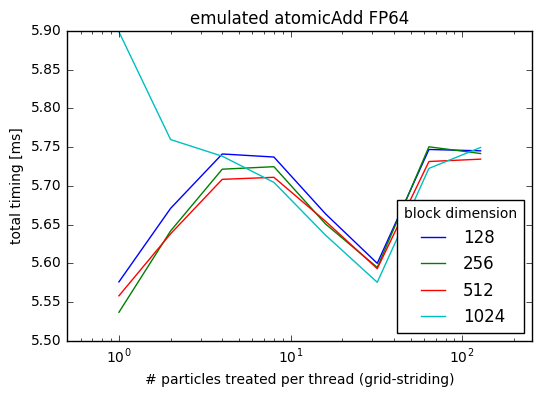

In [115]:
for block_dim, tres in timing_results.iteritems():
    plt.plot(n_particles_per_thread, tres, label=block_dim)
plt.legend(loc=4, title='block dimension')
plt.xscale('log')
plt.xlim(min(n_particles_per_thread) / 2, max(n_particles_per_thread) * 2)
plt.title('emulated atomicAdd FP64')
plt.xlabel('# particles treated per thread (grid-striding)')
plt.ylabel('total timing [ms]')

In [119]:
n_particles_per_thread = [1,2,4,8,16,32,64,128,256,512]
block_dims = [128, 256, 512, 1024]

timing_results2 = {}

for bd in block_dims:
    timing_results2[bd] = []
    for nppt in n_particles_per_thread:
        times = []
        for t in xrange(100):
            dest1 = gp.zeros(dest_size, dtype=np.float64)
            start.record()
            p2m_acc_gs.prepared_call(
                ((src_size // bd + 1) // nppt, 1, 1), #grid
                (bd, 1, 1), #block
                dest_size, src_size, 
                dest1.gpudata, src.gpudata)
            end.record()
            end.synchronize()
            times.append(start.time_till(end))
        timing_results2[bd].append(np.min(times))

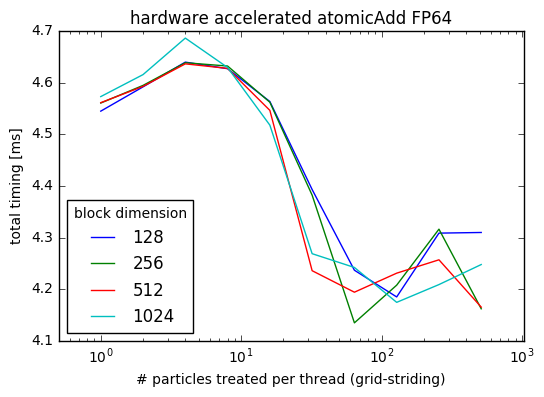

In [120]:
for block_dim, tres in timing_results2.iteritems():
    plt.plot(n_particles_per_thread, tres, label=block_dim)
plt.legend(loc=3, title='block dimension')
plt.xscale('log')
plt.xlim(min(n_particles_per_thread) / 2, max(n_particles_per_thread) * 2)
plt.title('hardware accelerated atomicAdd FP64')
plt.xlabel('# particles treated per thread (grid-striding)')
plt.ylabel('total timing [ms]');

In [123]:
4.15/5.55

0.7477477477477479

The grid-striding approach does not improve the emulated atomicAdd version. In contrast, it helps for the hardware accelerated atomicAdd version, where treating several particles per thread launch possibly profits from memory coalesced access.

$\implies$ By treating $\approx 100$ particles per thread launch, we can gain $10\%$ compared to 1 particle = 1 thread for the hardware accelerated atomicAdd. 

$\implies$ This means a $25\%$ total speed-up of the hardwareaccelerated atomicAdd with grid-striding compared to emulated double precision atomicAdd.